# 1_data_preparation.ipynb

Converts 'open-high-low-close' (OHLC) price data into a format suitable for machine learning.  Target labels are generated according to (potential) profitable trading conditions being met.  Extra data features are created, price and volume data are centralised around their moving averages, whilst time and day labels are separated out and one-hot encoded.  

The working dataframe is then transformed into a tensor of dimensions [batch_size, steps, channels] by using a rolling window method.  Appropriate category labels are selected to match the last step in each window, and transformed into a tensors of dimensions [batch_size, categories].

In [5]:
# from imports.noise_generator import NoiseGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import pickle

pd.set_option('display.max_columns', 50)

## Data Exploration

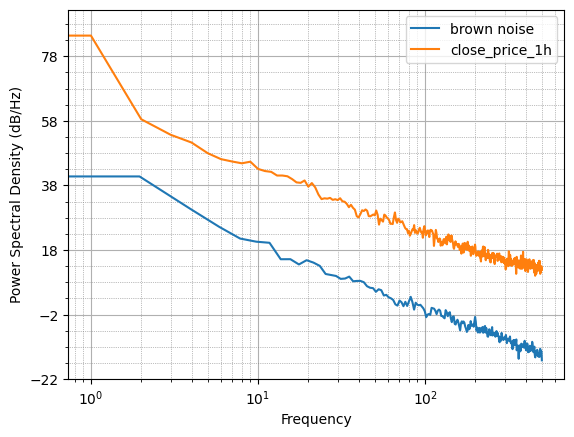

In [149]:
## compare power spectral density of closing prices with Brownian noise
df = pd.read_csv('data/OHLC_1h.csv', header=0, sep=',')
ng = NoiseGenerator()
brown_noise = ng.generate(dt=1e-5, n=10000, colour=ng.brown()) * 1000

# draw graph
plt.psd(brown_noise, 512, 1 / 0.001, label='brown noise')
plt.psd(df['close'].to_numpy(), 1000, 1 / 0.001, label='close_price_1h')
plt.xscale('log',base=10)
plt.minorticks_on()
plt.grid(which='minor', color='grey', linestyle=':', linewidth=0.5)
plt.legend()
plt.show()

The Power Spectral Density graph is as expected, and tells us that:
1. There are no dominant (long-term) cyclical pattens in the data.
2. There is some structure to the data... A 6dB/octave roll off. (NB: This 'structure' is also shared by brown noise and random walks).
4. First-order filters (which are characterised by a similar roll off) are therefore unable to fully detrend the data, so should be used/interpreted with care.


In [150]:
## compare Hurst exponent of closing prices with Brownian noise

def hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

for lag in [20, 100, 300, 500, 1000]:
    hurst_exp = hurst_exponent(df['close'].to_numpy(), lag)
    hurst_exp2 = hurst_exponent(brown_noise, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.3f} \t(brown noise = {hurst_exp2:.3f})")

Hurst exponent with 20 lags: 0.496 	(brown noise = 0.517)
Hurst exponent with 100 lags: 0.487 	(brown noise = 0.509)
Hurst exponent with 300 lags: 0.504 	(brown noise = 0.496)
Hurst exponent with 500 lags: 0.509 	(brown noise = 0.506)
Hurst exponent with 1000 lags: 0.517 	(brown noise = 0.505)


The Hurst exponent relates to the fractal dimension of a series.  The entire closing price series has a similar Hurst exponent to brown noise/random walks, although differences may be seen when looking at shorter timespans.  A rolling window method (with resampling to give a more robust estimate) can discover this... 

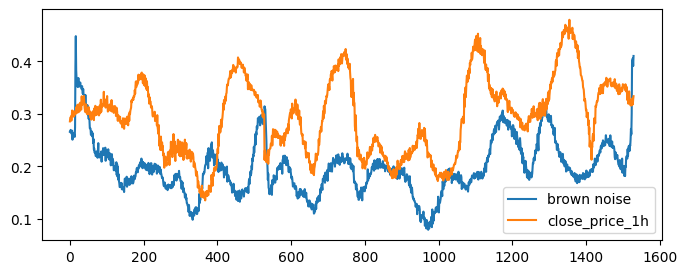

In [9]:
## compare short-term Hurst exponents of closing prices with Brownian noise
 
def hurst_fd(price_series, min_window=10, max_window=100, num_windows=20, num_samples=100):
    """ function to calculate Hurst exponent. from https://archive.is/6lD77 """
    log_returns = np.diff(np.log(price_series))
    window_sizes = np.linspace(min_window, max_window, num_windows, dtype=int)
    R_S = []
    
    # for each window size, calculate R/S values
    for w in window_sizes:
        R, S = [], []
        # resample multiple sequences for a more robust estimate
        for _ in range(num_samples):
            start = np.random.randint(0, len(log_returns) - w)
            seq = log_returns[start:start + w]
            R.append(np.max(seq) - np.min(seq))
            S.append(np.std(seq))
        R_S.append(np.mean(R) / np.mean(S))

    # calculate the slope (Hurst Exponent) in a log-log plot
    log_window_sizes = np.log(window_sizes)
    log_R_S = np.log(R_S)
    coeffs = np.polyfit(log_window_sizes, log_R_S, 1)

    # extract Hurst Exponent 
    hurst_exponent = coeffs[0]

    return hurst_exponent


def rolling_hurst(price_series, window, min_window=10, max_window=100, num_windows=20, num_samples=25):
    """ function to calculate rolling Hurst exponent """
    return price_series.rolling(window=window).apply(lambda x: hurst_fd(x, min_window, max_window, num_windows, num_samples), raw=True)


df = pd.read_csv('data/OHLC_1h.csv', header=0, sep=',')
ng = NoiseGenerator()
brown_noise = ng.generate(dt=1e-5, n=10000, colour=ng.brown()) * 1000

# generate graph
ROLLING_WINDOW = 120
df_hurst = pd.DataFrame(brown_noise[:3500])
df_hurst['brown noise'] = rolling_hurst(df_hurst, ROLLING_WINDOW)
df_hurst['close_price_1h'] = rolling_hurst(df['close'[:3500]], ROLLING_WINDOW)
df_hurst = df_hurst.dropna(axis=0).reset_index(drop=True)
df_hurst[:3000].plot(y=['brown noise', 'close_price_1h'], figsize=(8, 3))
plt.show()

When looking at shorter timespans the hourly closing prices show less tendency towards mean-reversion than a true random walk:  Prices have momentum, _i.e._ short-term trends are more prominent, in comparison.


## Alternative Method To Get Price Data

In [46]:
import requests
import time
import datetime
import pandas as pd
import numpy as np
import calendar

symbol = 'XBTUSD'
buckets = '1h'           # 1m,5m,1h,1d
allow_partials = False
data_length = 10000
resampled_buckets = '4h'  

response = requests.get(f'https://www.bitmex.com/api/v1/trade/bucketed?binSize={buckets}&partial={allow_partials}&symbol={symbol}&count={data_length}&reverse=true').json()

df = pd.DataFrame.from_dict(response)
df = df.iloc[::-1]   # reverse dataframe

df['hour'] = df.timestamp.str[11:13]
df['end_time_utc'] = pd.to_datetime(df['timestamp'], utc=False)
df['date'] = df.timestamp.str[0:10] + ' ' + df.timestamp.str[11:19]
df['unix'] = df.date.apply(lambda string : calendar.timegm(time.strptime(string, "%Y-%m-%d %H:%M:%S")))
df = df.set_index('end_time_utc')
df = df.drop(columns=['vwap', 'lastSize', 'turnover', 
                    'homeNotional', 'foreignNotional', 
                    'trades', 'symbol', 'timestamp'], axis=1)

if resampled_buckets:

    if allow_partials == 'false':
        # remove recent buckets that will form a partial bucket if resampled  
        while True:
            if int(df.tail(1)['hour']) % 12 == 0:
                break
            else: 
                df.drop(df.tail(1).index, inplace=True)

    ohlc_dict = {'open':'first', 'high':'max', 'low':'min', 'close':'last', 'hour':'first', 'volume':'sum', 'unix':'first', 'date':'first'}
    df2 = df.resample(resampled_buckets, offset=1).apply(ohlc_dict).dropna(how='any')
    df2.index.names = ['start_time_utc']
    # df2 = df2.drop(columns=['hour'], axis=1) 

    print(df.tail(8))
    print(df2.tail(2))

else:
    print(df.tail(8))


                              open     high      low    close    volume hour                 date        unix
end_time_utc                                                                                                 
2024-10-01 16:00:00+00:00  62558.9  62759.7  61777.0  62598.5  86170700   16  2024-10-01 16:00:00  1727798400
2024-10-01 17:00:00+00:00  62598.5  62734.8  61849.0  62404.0  31476200   17  2024-10-01 17:00:00  1727802000
2024-10-01 18:00:00+00:00  62404.0  62398.9  61015.0  62075.1  48412800   18  2024-10-01 18:00:00  1727805600
2024-10-01 19:00:00+00:00  62075.1  62384.4  61794.0  61925.3  25741700   19  2024-10-01 19:00:00  1727809200
2024-10-01 20:00:00+00:00  61925.3  62049.6  61536.7  61691.6  12668700   20  2024-10-01 20:00:00  1727812800
2024-10-01 21:00:00+00:00  61691.6  61720.0  60121.0  60762.9  84900500   21  2024-10-01 21:00:00  1727816400
2024-10-01 22:00:00+00:00  60762.9  61177.4  60602.8  61108.9  12091200   22  2024-10-01 22:00:00  1727820000
2024-10-01


## Feature Engineering
#### 1. Create categorical labels.

In [41]:
import numpy as np  
import pandas as pd


def convert_unix_time_into_day(seconds):
    """ returns day of week as category label """
    day_of_week = time.strftime('%A', time.localtime(seconds))
    dict = {'Saturday':1, 'Sunday':2, 'Monday':3, 'Tuesday':4, 'Wednesday':5, 'Thursday':6, 'Friday':7}
    day_code = dict[day_of_week]
    return day_code


def wwma(pd_series, period):
    """ w. wilder's exponential moving average """
    return pd_series.ewm(alpha=1/period, adjust=False, ignore_na=True).mean()


def atr(df, length=14):
    """ average true range (for column with latest values at top) """
    df_high, df_low, df_prev_close = df['high'], df['low'], df['close'].shift()
    df_tr = [df_high - df_low, df_high - df_prev_close, df_low - df_prev_close]
    df_tr = [tr.abs() for tr in df_tr]
    df_tr = pd.concat(df_tr, axis=1).max(axis=1)
    df_atr = wwma(df_tr, length)
    return df_atr


PERCENT_CHANGE = False    # Must be false - adding NaNs?
PERIOD = 30                 
PERIOD_FAST = 11          
ISHIMOKU_SCALE = 4
WINDOW = 20
STEP = 2
COMMISSION_FRAC = 0.001
COMMISSION_MULT = 5  
ATR_MULT = 0.25
RUN_ID = '6'

# load price data into dataframe and reorder to most recent at bottom
df = pd.read_csv('data/OHLC_1h.csv', header=0, sep=',')
df = df.sort_index(ascending=False, ignore_index=True)

# calculate average true range
df_atr = atr(df)
df['ATR'] = df_atr

# create target labels 
y_labels =[]

for i in range(2,len(df)):

    # up condition: (high or high[1] > close[2] + spread) and (low and low[1] > low[2] + spread)     
    if (
        ( df.loc[i, 'high'] > (df.loc[i-2, 'close'] + ATR_MULT * df.loc[i, 'ATR'])  or  
        df.loc[i-1, 'high'] > (df.loc[i-2, 'close'] + ATR_MULT * df.loc[i, 'ATR']) )  and 

        ( df.loc[i, 'high'] > (df.loc[i-2, 'close'] * (1 + COMMISSION_FRAC * COMMISSION_MULT))  or  
        df.loc[i-1, 'high'] > (df.loc[i-2, 'close'] * (1 + COMMISSION_FRAC * COMMISSION_MULT)) )  and

        ( df.loc[i, 'low'] > (df.loc[i-2, 'low'] + ATR_MULT * df.loc[i, 'ATR'])  and  
        df.loc[i-1, 'low'] > (df.loc[i-2, 'low'] + ATR_MULT * df.loc[i, 'ATR']) )
    ):
        label = 'up'

    # down condition: (low or low[1] < close[2] - spread) and (high and high[1] < high[2] - spread)    
    elif (
        ( df.loc[i, 'low'] < (df.loc[i-2, 'close'] - ATR_MULT * df.loc[i, 'ATR'])  or  
          df.loc[i-1, 'low'] < (df.loc[i-2, 'close'] - ATR_MULT * df.loc[i, 'ATR']) )  and 
          
        ( df.loc[i, 'low'] < (df.loc[i-2, 'close'] * (1 - COMMISSION_FRAC * COMMISSION_MULT))  or  
          df.loc[i-1, 'low'] < (df.loc[i-2, 'close'] * (1 - COMMISSION_FRAC * COMMISSION_MULT)) )  and

        ( df.loc[i, 'high'] < (df.loc[i-2, 'high'] - ATR_MULT * df.loc[i, 'ATR'])  and  
          df.loc[i-1, 'high'] < (df.loc[i-2, 'high'] - ATR_MULT * df.loc[i, 'ATR']) )
    ):
        label = 'down'
    
    else:
        label = 'flat'

    y_labels.append(label)

y_labels.extend([float('NaN'), float('NaN')])

# add labels to new dataframe column
df['target'] = y_labels

# create day and hour categories
df['day'] = df['unix'].map(lambda x: convert_unix_time_into_day(x))
df['hour'] = df['date'].str.slice(start=11, stop=13).apply(pd.to_numeric)
df['year'] = df['date'].str.slice(start=0, stop=4).apply(pd.to_numeric)

pd.set_option("expand_frame_repr", False)
pd.set_option("display.max_columns", 100)
print(df.head())

df_ylabels = df['target'].copy()
df_ylabels = pd.get_dummies(df_ylabels, columns=['target'])
print(f'COUNT: {len(df)}\n', df_ylabels.sum(axis=0))
del df_ylabels

         unix                 date     open     high      low    close       volume  volume USD        ATR target  day  hour  year
0  1526364000  2018-05-15 06:00:00  8733.86  8796.68  8707.28  8740.99   4906603.14      559.93  89.400000   down    4     6  2018
1  1526367600  2018-05-15 07:00:00  8740.99  8766.00  8721.11  8739.00   2390398.89      273.58  86.220714   flat    4     7  2018
2  1526371200  2018-05-15 08:00:00  8739.00  8750.27  8660.53  8728.49   7986062.84      917.79  86.472092     up    4     8  2018
3  1526374800  2018-05-15 09:00:00  8728.49  8754.40  8701.35  8708.32   1593991.98      182.62  84.084800   flat    4     9  2018
4  1526378400  2018-05-15 10:00:00  8708.32  8865.00  8695.11  8795.90  11101273.74     1260.69  90.213742   down    4    10  2018
COUNT: 50515
 down     6850
flat    36154
up       7509
dtype: int64


#### 2. Create features using variance, filters, significant levels, volume indicators, and fractal dimension

In [42]:

import math
#import numba


def bollinger_k(df, length=20):
    """ bollinger coeffient and delta standard deviation"""
    df_tp = (df['high'] + df['low'] + df['close']) / 3
    df_sma = df_tp.rolling(length).mean()
    df_sdev = df_tp.rolling(length).std()
    df_delta_sdev = df_sdev.diff()
    df_bk = (df['close'] - df_sma) / df_sdev 
    return df_bk, df_delta_sdev


def rr_vwap(dataframe, length):
    """ relative rolling volume-weighted average price """
    df = dataframe.copy()
    df['period_total'] = (df['high'] + df['low'] + df['close'] / 3) * df['volume']
    df['cum_tot'] = df['period_total'].rolling(length).sum()
    df['cum_vol'] = df['volume'].rolling(length).sum()
    df_rvwap = df['close'] - (df['cum_tot'] / df['cum_vol']) / df['close']
    return df_rvwap


# @numba.jit
def frama(dataframe, batch=10):
    """ fractal adaptive moving average """
    df = dataframe.copy() 
    price = df.close  
    fractal_dims = []
    filtered_prices = np.array(price)

    for i in range(0, len(df)):  
        
        if i < 2 * batch:  
            fractal_dims.append(np.nan)
            continue  

        v1 = price[i-2*batch : i - batch]  
        v2 = price[i - batch : i]
        H1 = np.max(v1)  
        L1 = np.min(v1)  
        N1 = (H1 - L1) / batch
        H2 = np.max(v2)  
        L2 = np.min(v2)  
        N2 = (H2 - L2) / batch
        H = np.max([H1, H2])  
        L = np.min([L1, L2])  
        N3 = (H - L) / (2 * batch)

        fractal_dim = 0  
        if N1 > 0 and N2 > 0 and N3 > 0:  
            fractal_dim = (np.log(N1 + N2) - np.log(N3)) / np.log(2)
        fractal_dims.append(fractal_dim)

        alpha = np.exp(-4.6 * (fractal_dim - 1))    # 4.6 limits slow EMA length < 200 
        alpha = np.max([alpha, 0.1])  
        alpha = np.min([alpha, 1])

        filtered_prices[i] = alpha * price[i] + (1 - alpha) * filtered_prices[i-1]    # single-pole lowpass filter

    df['frama'] = filtered_prices
    df['d_frama'] = df['frama'] - df['frama'].shift(1)
    df['rel_frama'] = df['frama'] / df['close']
    df['frac_dim'] = fractal_dims
    df['d_frac_dim'] = df['frac_dim'] - df['frac_dim'].shift(1)

    return df.d_frama, df.rel_frama, df.frac_dim, df.d_frac_dim


# @numba.jit
def z_transformer(dataframe, mode, period):
    """ digital signal processor based on a generalised z-domain transfer function """
    df = dataframe.copy() 
    price = df.close  
    transformed_prices = np.array(price)

    pi = 3.14159
    c1, N, b1, b2, a1, a2 = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    b0 = 1.0

    if mode == 'highpass':
        threshold_period = period
        alpha = (math.cos(2.0*pi/threshold_period) + math.sin(2.0*pi/threshold_period) - 1) / math.cos(2.0*pi/threshold_period)
        c0 = 1.0 - alpha / 2.0
        b1 = -1.0
        a1 = 1.0 - alpha

    if mode == 'bandpass':
        centre_period = period
        delta = 0.2    # half-bandwidth fraction: min=0.05, max=0.5
        beta = math.cos(2.0*pi / centre_period)
        gamma = 1.0 / math.cos(4.0*pi*delta / centre_period)
        alpha = gamma - math.sqrt(gamma**2 - 1.0)
        c0 = (1.0 - alpha) / 2.0
        b2 = -1.0
        a1 = beta * (alpha + 1.0)
        a2 = -alpha

    for i in range(0, len(df)):  
        if i < 2:  
            continue  

        transformed_prices[i] = c0 * (b0*price[i] + b1*price[i-1] + b2*price[i-2]) + a1*transformed_prices[i-1] + a2*transformed_prices[i-2] # - c1*price[N]

    df['output'] = transformed_prices
    df['delta_output'] = df.output - df.output.shift(1)
    df['relative_output'] = df.output / df.close

    return df.output, df.delta_output, df.relative_output


def ema(pd_series, period):
    """ exponential moving average """
    return pd_series.ewm(alpha=1/period, adjust=False, ignore_na=True).mean()


# @numba.jit
def rma(x, n):
    """ running moving average """
    a = np.full_like(x, np.nan)
    a[n] = x[1:n+1].mean()
    for i in range(n+1, len(x)):
        a[i] = (a[i-1] * (n - 1) + x[i]) / n
    return a


def detrended_rsi(dataframe, hp_threshold=8, rsi_period=14):
    """ relative strength index of high-frequency component of price """
    df = dataframe.copy()

    df['detrended_price'] = z_transformer(df, mode='highpass', period=hp_threshold)[0]
    df['change'] = df['detrended_price'].diff()
    df['gain'] = df.change.mask(df.change < 0, 0.0)
    df['loss'] = -df.change.mask(df.change > 0, -0.0)

    df['avg_gain'] = rma(df.gain.to_numpy(), rsi_period)
    df['avg_loss'] = rma(df.loss.to_numpy(), rsi_period)

    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1 + df.rs))

    return df.rsi


def acc_dis_mfv(dataframe):
    """ accumulation-distribution indicator """
    df = dataframe.copy()
    price = df.close  
    acc_dis = np.array(price)
    df['mfv'] = df.volume * ((df.close - df.low) - (df.high - df.close)) / (df.high - df.low + 1)
    mfv = df['mfv'].to_numpy()

    for i in range(0, len(df)):  
        if i < 1:  
            continue  

        # if acc_dis[i-1] == np.nan:
        #     acc_dis[i-1] = price[i-1]

        acc_dis[i] = acc_dis[i-1] + mfv[i]
    df['acc_dis'] = acc_dis

    return df.acc_dis, df.mfv


def obv(dataframe):
    """ on-balance-volume indicator """
    df = dataframe.copy()
    volume = df.volume
    price = df.close  
    obv = np.array(volume)

    for i in range(0, len(df)):  
        if i < 1:  
            continue  
        if price[i] > price[i-1]: new = volume[i]
        if price[i] == price[i-1]: new = 0.0
        if price[i] < price[i-1]: new = -volume[i]
        obv[i] = obv[i-1] + new

    df['obv'] = obv
    return df.obv


# calculate simple moving averages of closing price
df[f'SMA_{PERIOD}'] = df['close'].rolling(PERIOD).mean()
df[f'SMA_{PERIOD_FAST}'] = df['close'].rolling(PERIOD_FAST).mean()

# calculate simple moving averages of volume
df[f'vol SMA_{PERIOD}'] = df['volume USD'].rolling(PERIOD).mean()
df[f'vol SMA_{PERIOD_FAST}'] = df['volume USD'].rolling(PERIOD_FAST).mean()

# centralise price and volume data around relevant slower SMA
df['open_'] = (df['open'] - df[f'SMA_{PERIOD}']) / df[f'SMA_{PERIOD}']
df['high_'] = (df['high'] - df[f'SMA_{PERIOD}']) / df[f'SMA_{PERIOD}']
df['low_'] = (df['low'] - df[f'SMA_{PERIOD}']) / df[f'SMA_{PERIOD}']
df['close_'] = (df['close'] - df[f'SMA_{PERIOD}']) / df[f'SMA_{PERIOD}']
df['vol_'] = (df['volume USD'] - df[f'vol SMA_{PERIOD}']) / df[f'vol SMA_{PERIOD}']

# centralise price and volume data around relevant faster SMA
df['close_f'] = (df['close'] - df[f'SMA_{PERIOD_FAST}']) / df[f'SMA_{PERIOD_FAST}']
df['vol_f'] = (df['volume USD'] - df[f'vol SMA_{PERIOD_FAST}']) / df[f'vol SMA_{PERIOD_FAST}']

# calculate highest high and lowest low in the last 'PERIOD_FAST*2' prices
df[f'HH{PERIOD_FAST*2}'] = df['high'].rolling(PERIOD_FAST*2).max().shift()
df[f'LL{PERIOD_FAST*2}'] = df['low'].rolling(PERIOD_FAST*2).min().shift()

# close price fraction of highest high and lowest low 
df['chh_'] = (df['close'] - df[f'HH{PERIOD_FAST*2}']) / df[f'HH{PERIOD_FAST*2}']
df['cll_'] = (df[f'LL{PERIOD_FAST*2}'] - df['close']) / df[f'LL{PERIOD_FAST*2}']

# calculate bollinger coeffient and standard deviation add as column to dataframe
df['bk'], df['d_sdev'] = bollinger_k(df, length=PERIOD_FAST)

# deltas
df['c-c1'] = df['close'] - df['close'].shift(1)
df['h-h1'] = df['high'] - df['high'].shift(1)
df['l-l1'] = df['low'] - df['low'].shift(1)
df['v-v1'] = df['volume'] - df['volume'].shift(1)
df['hlc-hlc1'] = (df['high'] + df['low'] + df['close'] / 3) - (df['high'].shift(1) + df['low'].shift(1) + df['close'].shift(1) / 3)
df['vwp-vwp1'] = ((df['high'] + df['low'] + df['close'] / 3) * df['volume']) - ((df['high'].shift(1) + df['low'].shift(1) + df['close'].shift(1) / 3) * df['volume'].shift(1))

# relative volume-weighted average price
df['rr_wvap_fast'] = rr_vwap(df, length=7)
df['rr_wvap'] = rr_vwap(df, length=PERIOD)

# volume indicators
df['obv'] = obv(df)
df['acc_dis'], df['mfv'] = acc_dis_mfv(df)

# ishimoku cloud relative to close price
df['tenkan'] = ((df['high'].rolling(ISHIMOKU_SCALE * 1).max() + df['low'].rolling(ISHIMOKU_SCALE * 1).min()) / 2) / df['close']
df['kijun'] = ((df['high'].rolling(ISHIMOKU_SCALE * 3).max() + df['low'].rolling(ISHIMOKU_SCALE * 3).min()) / 2) / df['close']
df['senkou_a'] = (df['tenkan'] + df['kijun']) / 2
df['senkou_b'] = (df['high'].rolling(ISHIMOKU_SCALE * 6).max() + df['low'].rolling(ISHIMOKU_SCALE * 6).min()) / 2
df['senkou'] = (df['senkou_a'] - df['senkou_b']) / df['close']
df['senkou_a'] = df['senkou_a'] / df['close']
df['senkou_b'] = df['senkou_b'] / df['close']

# fractal adaptive moving average
df['d_frama'], df['rel_frama'], df['frac_dim'], df['d_frac_dim'] = frama(df, batch=10)

# negative group delay bandpass array
df['ngd_3'] = z_transformer(df, mode='bandpass', period=3)[0]   
df['ngd_4'] = z_transformer(df, mode='bandpass', period=4)[0]   
df['ngd_6'] = z_transformer(df, mode='bandpass', period=6)[0]      
df['ngd_8'] = z_transformer(df, mode='bandpass', period=8)[0]     
df['ngd_11'] = z_transformer(df, mode='bandpass', period=11)[0]    
df['ngd_16'] = z_transformer(df, mode='bandpass', period=16)[0]    
df['ngd_22'] = z_transformer(df, mode='bandpass', period=22)[0]   
df['ngd_32'] = z_transformer(df, mode='bandpass', period=32)[0]   

# detrended relative strength index
df['drsi_7'] = detrended_rsi(df, hp_threshold=7, rsi_period=7)
df['drsi_14'] = detrended_rsi(df, hp_threshold=14, rsi_period=14)
df['drsi_21'] = detrended_rsi(df, hp_threshold=21, rsi_period=14)

# # capture indices of NaN rows to also remove from outcomes list
# nan_indices = df.index[df.isnull().any(axis=1)].tolist()

df = df.dropna(axis=0)
df.reset_index(drop=True, inplace=True)

# check dataframe
print(df.head())
print(df.tail())
print(len(df))

         unix                 date     open     high     low    close      volume  volume USD         ATR target  day  hour  year       SMA_30       SMA_11  vol SMA_30  vol SMA_11     open_     high_      low_    close_      vol_   close_f     vol_f     HH22     LL22      chh_      cll_        bk     d_sdev    c-c1    h-h1   l-l1        v-v1    hlc-hlc1      vwp-vwp1  rr_wvap_fast      rr_wvap          obv       acc_dis           mfv    tenkan     kijun  senkou_a  senkou_b    senkou    d_frama  rel_frama  frac_dim  d_frac_dim      ngd_3      ngd_4      ngd_6      ngd_8      ngd_11      ngd_16       ngd_22       ngd_32     drsi_7    drsi_14    drsi_21
0  1526468400  2018-05-16 11:00:00  8371.13  8439.44  8370.0  8373.00  2680259.87      319.29  104.106814   down    5    11  2018  8477.674667  8249.193636  592.550000  662.216364 -0.012568 -0.004510 -0.012701 -0.012347 -0.461159  0.015008 -0.517846  8771.02  8100.01 -0.045379 -0.033702  1.536641 -14.265967    1.87  -16.22  132.9 -4987234.

#### 3. Calculate profit/loss fraction for each trade direction and timestamp

In [43]:
import random

WINDOW = 20
STEP = 2
ATR_MULT_TP = 0.25
ATR_MULT_SL = 0.25
COMMISSION_FRAC = 0.001
PL_ID = 'b'

up_outcomes = []
up_outcomes_passive = []

# tp_frac = ((df.loc[i, 'close'] + (ATR_MULT * df.loc[i, 'ATR'])) / df.loc[i, 'close']) - COMMISSION_FRAC
# sl_frac = ((df.loc[i, 'low'] - ATR_MULT * df.loc[i, 'ATR']) / df.loc[i, 'close']) - COMMISSION_FRAC

for i in range(len(df)-2):

    if bool(random.getrandbits(1)) == True:    # randomises order of whether tp or sl is hit first if both are crossed

        if df.loc[i+1, 'low'] < (df.loc[i, 'close'] - ATR_MULT_SL * df.loc[i, 'ATR']):
            up_outcomes.append(((df.loc[i, 'close'] - ATR_MULT_SL * df.loc[i, 'ATR']) / df.loc[i, 'close']) - COMMISSION_FRAC)  

        elif df.loc[i+1, 'high'] > (df.loc[i, 'close'] + ATR_MULT_TP * df.loc[i, 'ATR']):    
            up_outcomes.append(((df.loc[i, 'close'] + (ATR_MULT_TP * df.loc[i, 'ATR'])) / df.loc[i, 'close']) - COMMISSION_FRAC)

        elif df.loc[i+2, 'low'] < (df.loc[i, 'close'] - ATR_MULT_SL * df.loc[i, 'ATR']):
            up_outcomes.append(((df.loc[i, 'close'] - ATR_MULT_SL * df.loc[i, 'ATR']) / df.loc[i, 'close']) - COMMISSION_FRAC)

        elif df.loc[i+2, 'high'] > (df.loc[i, 'close'] + ATR_MULT_TP * df.loc[i, 'ATR']):
            up_outcomes.append(((df.loc[i, 'close'] + (ATR_MULT_TP * df.loc[i, 'ATR'])) / df.loc[i, 'close']) - COMMISSION_FRAC)

        else:
            up_outcomes.append((df.loc[i+2, 'close'] / df.loc[i, 'close']) - COMMISSION_FRAC)

        up_outcomes_passive.append((df.loc[i+2, 'close'] / df.loc[i, 'close']) - (1.5 * COMMISSION_FRAC))

    else:
        if df.loc[i+1, 'high'] > (df.loc[i, 'close'] + ATR_MULT_TP * df.loc[i, 'ATR']):    
            up_outcomes.append(((df.loc[i, 'close'] + (ATR_MULT_TP * df.loc[i, 'ATR'])) / df.loc[i, 'close']) - COMMISSION_FRAC)      

        elif df.loc[i+1, 'low'] < (df.loc[i, 'close'] - ATR_MULT_SL * df.loc[i, 'ATR']):
            up_outcomes.append(((df.loc[i, 'close'] - ATR_MULT_SL * df.loc[i, 'ATR']) / df.loc[i, 'close']) - COMMISSION_FRAC)  

        elif df.loc[i+2, 'high'] > (df.loc[i, 'close'] + ATR_MULT_TP * df.loc[i, 'ATR']):
            up_outcomes.append(((df.loc[i, 'close'] + (ATR_MULT_TP * df.loc[i, 'ATR'])) / df.loc[i, 'close']) - COMMISSION_FRAC)

        elif df.loc[i+2, 'low'] < (df.loc[i, 'close'] - ATR_MULT_SL * df.loc[i, 'ATR']):
            up_outcomes.append(((df.loc[i, 'close'] - ATR_MULT_SL * df.loc[i, 'ATR']) / df.loc[i, 'close']) - COMMISSION_FRAC)

        else:
            up_outcomes.append((df.loc[i+2, 'close'] / df.loc[i, 'close']) - COMMISSION_FRAC)

        up_outcomes_passive.append((df.loc[i+2, 'close'] / df.loc[i, 'close']) - (1.5 * COMMISSION_FRAC))

up_outcomes.extend([float('NaN'), float('NaN')])
up_outcomes_passive.extend([float('NaN'), float('NaN')])


dn_outcomes = []
dn_outcomes_passive = []

# tp_frac = (df.loc[i, 'close'] / (df.loc[i, 'close'] - (ATR_MULT * df.loc[i, 'ATR']))) - COMMISSION_FRAC 
# sl_frac = (df.loc[i, 'close'] / (df.loc[i, 'high'] + ATR_MULT * df.loc[i, 'ATR'])) - COMMISSION_FRAC   

for i in range(len(df)-2):

    if bool(random.getrandbits(1)) == True:    

        if df.loc[i+1, 'high'] > (df.loc[i, 'close'] + ATR_MULT_SL * df.loc[i, 'ATR']):
            dn_outcomes.append((df.loc[i, 'close'] / (df.loc[i, 'close'] + ATR_MULT_SL * df.loc[i, 'ATR'])) - COMMISSION_FRAC) 

        elif df.loc[i+1, 'low'] < (df.loc[i, 'close'] - ATR_MULT_TP * df.loc[i, 'ATR']):    
            dn_outcomes.append((df.loc[i, 'close'] / (df.loc[i, 'close'] - (ATR_MULT_TP * df.loc[i, 'ATR']))) - COMMISSION_FRAC) 

        elif df.loc[i+2, 'high'] > (df.loc[i, 'close'] + ATR_MULT_SL * df.loc[i, 'ATR']):
            dn_outcomes.append((df.loc[i, 'close'] / (df.loc[i, 'close'] + ATR_MULT_SL * df.loc[i, 'ATR'])) - COMMISSION_FRAC) 

        elif df.loc[i+2, 'low'] < (df.loc[i, 'close'] - ATR_MULT_TP * df.loc[i, 'ATR']):
            dn_outcomes.append((df.loc[i, 'close'] / (df.loc[i, 'close'] - (ATR_MULT_TP * df.loc[i, 'ATR']))) - COMMISSION_FRAC)

        else:
            dn_outcomes.append((df.loc[i, 'close'] / df.loc[i+2, 'close']) - COMMISSION_FRAC)

        dn_outcomes_passive.append((df.loc[i, 'close'] / df.loc[i+2, 'close']) - (1.5 * COMMISSION_FRAC))

    else:    

        if df.loc[i+1, 'low'] < (df.loc[i, 'close'] - ATR_MULT_TP * df.loc[i, 'ATR']):    
            dn_outcomes.append((df.loc[i, 'close'] / (df.loc[i, 'close'] - (ATR_MULT_TP * df.loc[i, 'ATR']))) - COMMISSION_FRAC) 

        elif df.loc[i+1, 'high'] > (df.loc[i, 'close'] + ATR_MULT_SL * df.loc[i, 'ATR']):
            dn_outcomes.append((df.loc[i, 'close'] / (df.loc[i, 'close'] + ATR_MULT_SL * df.loc[i, 'ATR'])) - COMMISSION_FRAC) 

        elif df.loc[i+2, 'low'] < (df.loc[i, 'close'] - ATR_MULT_TP * df.loc[i, 'ATR']):
            dn_outcomes.append((df.loc[i, 'close'] / (df.loc[i, 'close'] - (ATR_MULT_TP * df.loc[i, 'ATR']))) - COMMISSION_FRAC)

        elif df.loc[i+2, 'high'] > (df.loc[i, 'close'] + ATR_MULT_SL * df.loc[i, 'ATR']):
            dn_outcomes.append((df.loc[i, 'close'] / (df.loc[i, 'close'] + ATR_MULT_SL * df.loc[i, 'ATR'])) - COMMISSION_FRAC) 

        else:
            dn_outcomes.append((df.loc[i, 'close'] / df.loc[i+2, 'close']) - COMMISSION_FRAC)

        dn_outcomes_passive.append((df.loc[i, 'close'] / df.loc[i+2, 'close']) - (1.5 * COMMISSION_FRAC))

dn_outcomes.extend([float('NaN'), float('NaN')])
dn_outcomes_passive.extend([float('NaN'), float('NaN')])

# # remove NaN rows to match main dataframe
# for index in sorted(nan_indices, reverse=True):
#     try:
#         del up_outcomes[index]
#         del dn_outcomes[index]
#         del up_outcomes_passive[index]
#         del dn_outcomes_passive[index]
#     except:
#         print('index out of range ', index)

# print(len(up_outcomes))
# print(len(dn_outcomes))
# print(len(up_outcomes_passive))
# print(len(dn_outcomes_passive))


# filter results to match slicing of input tensors
up_outcomes = [up_outcomes[i] for i in range(WINDOW, len(df), STEP)]
dn_outcomes = [dn_outcomes[i] for i in range(WINDOW, len(df), STEP)]
up_outcomes_passive = [up_outcomes_passive[i] for i in range(WINDOW, len(df), STEP)]
dn_outcomes_passive = [dn_outcomes_passive[i] for i in range(WINDOW, len(df), STEP)]

print(len(up_outcomes))
print(len(dn_outcomes))
print(len(up_outcomes_passive))
print(len(dn_outcomes_passive))

# save data
with open(f'data/outcomes_{RUN_ID}{PL_ID}.pkl', 'wb') as file:
    pickle.dump((up_outcomes, dn_outcomes, up_outcomes_passive, dn_outcomes_passive), file, protocol=4)

25232
25232
25232
25232


#### 4. Separate catagorical dataframes and convert to one-hot encoding.

In [16]:
# create separate dataframe for one-hot encoded day/hour categories
df_time = df[['day', 'hour', 'year']].copy()
df_time = pd.get_dummies(df_time, columns=['day', 'hour', 'year'])

# create separate dataframe for one-hot encoded target categories
df_ylabels = df['target'].copy()
df_ylabels = pd.get_dummies(df_ylabels, columns=['target'])

# tidy up price data
df = df.drop(columns=['unix', 'date', 'volume USD', 'volume', 
                      'open', 'high', 'low', 'close', 
                      f'SMA_{PERIOD}', f'SMA_{PERIOD_FAST}', 
                      f'vol SMA_{PERIOD}', f'vol SMA_{PERIOD_FAST}', 
                      'day', 'hour', 'year', 'target', 'ATR', 'open_',
                      f'HH{PERIOD_FAST*2}', f'LL{PERIOD_FAST*2}', 
                      ], axis=1)

# check dataframes
print(df.head(), '\n', len(df))
print(df_time.head(), '\n', len(df_time))
print(df_ylabels.head(), '\n', len(df_ylabels))

      high_      low_    close_      vol_   close_f     vol_f      chh_      cll_        bk     d_sdev    c-c1    h-h1   l-l1        v-v1    hlc-hlc1      vwp-vwp1  rr_wvap_fast      rr_wvap          obv       acc_dis           mfv    tenkan     kijun  senkou_a  senkou_b    senkou    d_frama  rel_frama  frac_dim  d_frac_dim      ngd_3      ngd_4      ngd_6      ngd_8      ngd_11      ngd_16       ngd_22       ngd_32     drsi_7    drsi_14    drsi_21
0 -0.004510 -0.012701 -0.012347 -0.461159  0.015008 -0.517846 -0.045379 -0.033702  1.536641 -14.265967    1.87  -16.22  132.9 -4987234.43  117.303333 -9.685257e+10   8370.694027  8370.636398 -22020735.69 -7.651111e+06 -2.413908e+06  0.994605  0.991600  0.000119  1.009113 -1.008995   1.870000   1.000000  0.676550   -0.309439   1.356111  28.734731  52.347200 -79.173469 -296.162754 -147.514770   163.464996  1563.706205  28.107646   8.320180   8.272585
1 -0.007802 -0.012846 -0.011821 -0.382186  0.013615 -0.394398 -0.045267 -0.032725  1.380993   

#### 5. Scale standard deviations of selected columns then check overall balance of data

In [17]:
import pickle

if PERCENT_CHANGE == True:
    df = df.pct_change()
    print(df.head())
    print(df.tail())
    df = df.dropna(axis=0)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

# scale column stdev with stdev(close_)
df['high_'] = df['high_'] / df['close_'].std()
df['low_'] = df['low_'] / df['close_'].std()
df['close_'] = df['close_'] / df['close_'].std()

# scale column stdev to unity
df['vol_'] = (df['vol_'] - df['vol_'].mean()) / df['vol_'].std()   
df['close_f'] = df['close_f'] / df['close_f'].std()
df['vol_f'] = df['vol_f'] / df['vol_f'].std()
df['chh_'] = (df['chh_'] - df['chh_'].mean()) / df['chh_'].std()
df['cll_'] = (df['cll_'] - df['cll_'].mean()) / df['cll_'].std()
df['bk'] = df['bk'] / df['bk'].std()
df['d_sdev'] = df['d_sdev'] / df['d_sdev'].std()
df['rr_wvap_fast'] = (df['rr_wvap_fast'] - df['rr_wvap_fast'].mean()) / df['rr_wvap_fast'].std()
df['rr_wvap'] = (df['rr_wvap'] - df['rr_wvap'].mean()) / df['rr_wvap'].std()
df['vwp-vwp1'] = df['vwp-vwp1'] / df['vwp-vwp1'].std()

df['c-c1'] = df['c-c1'] / df['c-c1'].std()
df['h-h1'] = df['h-h1'] / df['h-h1'].std()      # are these just replicating first layer's filters?
df['l-l1'] = df['l-l1'] / df['l-l1'].std()
df['v-v1'] = df['v-v1'] / df['v-v1'].std()
df['hlc-hlc1'] = df['hlc-hlc1'] / df['hlc-hlc1'].std()

df['tenkan'] = (df['tenkan'] - df['tenkan'].mean()) / df['tenkan'].std()    
df['kijun'] = (df['kijun'] - df['kijun'].mean()) / df['kijun'].std()
df['senkou'] = (df['senkou'] - df['senkou'].mean()) / df['senkou'].std()
df['senkou_a'] = (df['senkou_a'] - df['senkou_a'].mean()) / df['senkou_a'].std()
df['senkou_b'] = (df['senkou_b'] - df['senkou_b'].mean()) / df['senkou_b'].std()

df['acc_dis'] = (df['acc_dis'] - df['acc_dis'].mean()) / df['acc_dis'].std()
df['obv'] = (df['obv'] - df['obv'].mean()) / df['obv'].std()
df['mfv'] = (df['mfv'] - df['mfv'].mean()) / df['mfv'].std()

df['d_frama'] = (df['d_frama'] - df['d_frama'].mean()) / df['d_frama'].std()    
df['rel_frama'] = (df['rel_frama'] - df['rel_frama'].mean()) / df['rel_frama'].std()
df['frac_dim'] = (df['frac_dim'] - df['frac_dim'].mean()) / df['frac_dim'].std()
df['d_frac_dim'] = (df['d_frac_dim'] - df['d_frac_dim'].mean()) / df['d_frac_dim'].std()

df['drsi_7'] = (df['drsi_7'] - df['drsi_7'].mean()) / df['drsi_7'].std()
df['drsi_14'] = (df['drsi_14'] - df['drsi_14'].mean()) / df['drsi_14'].std()
df['drsi_21'] = (df['drsi_21'] - df['drsi_21'].mean()) / df['drsi_21'].std()

df['ngd_3'] = (df['ngd_3'] - df['ngd_3'].mean()) / df['ngd_3'].std()
df['ngd_4'] = (df['ngd_4'] - df['ngd_4'].mean()) / df['ngd_4'].std()
df['ngd_6'] = (df['ngd_6'] - df['ngd_6'].mean()) / df['ngd_6'].std()
df['ngd_8'] = (df['ngd_8'] - df['ngd_8'].mean()) / df['ngd_8'].std()
df['ngd_11'] = (df['ngd_11'] - df['ngd_11'].mean()) / df['ngd_11'].std()
df['ngd_16'] = (df['ngd_16'] - df['ngd_16'].mean()) / df['ngd_16'].std()
df['ngd_22'] = (df['ngd_22'] - df['ngd_22'].mean()) / df['ngd_22'].std()
df['ngd_32'] = (df['ngd_32'] - df['ngd_32'].mean()) / df['ngd_32'].std()

# check data
print(f'COUNT: {len(df)}\n', df_ylabels.sum(axis=0))
print('MEANS:\n', df.mean())
print('STDEVS:\n', df.std())

# save data
with open(f'data/dataframes_{RUN_ID}.pkl', 'wb') as file:
    pickle.dump((df, df_time, df_ylabels), file, protocol=4)

COUNT: 50484
 down     6845
flat    36135
up       7504
dtype: int64
MEANS:
 high_           2.301352e-01
low_           -1.889741e-01
close_          2.900061e-02
vol_           -6.843780e-18
close_f         1.703022e-02
vol_f           4.593239e-02
chh_            7.656589e-17
cll_           -7.825485e-17
bk              4.016762e-02
d_sdev          9.841987e-05
c-c1            4.121209e-03
h-h1            4.586821e-03
l-l1            3.793377e-03
v-v1           -7.195549e-05
hlc-hlc1        5.064199e-03
vwp-vwp1       -6.513259e-05
rr_wvap_fast   -6.755814e-17
rr_wvap        -1.261085e-16
obv             3.377907e-16
acc_dis         1.846589e-16
mfv            -4.644622e-18
tenkan          6.161302e-15
kijun           8.948216e-15
senkou_a       -3.377907e-16
senkou_b       -4.258133e-15
senkou         -1.090219e-15
d_frama         5.066860e-18
rel_frama      -1.176789e-14
frac_dim        1.481071e-15
d_frac_dim     -3.615416e-18
ngd_3          -2.744549e-18
ngd_4           1.140044

## Prepare Tensors
#### Slices dataframe into many discrete classification problems.

In [18]:
# from numba import jit


# @jit
def prepare_tensors(df, df_time, df_ylabels, window, step): 

    # create numpy arrays to receive data
    price_series = np.zeros(shape=(window, len(df.columns)))
    time_categories = np.zeros(shape=(1, len(df_time.columns)))
    target_categories = np.zeros(shape=(1, 3))

    # iterate through price dataframe concatenating discrete arrays of size 'window', and spacing 'step'
    batch_size = (len(df)-window) // step
    for i in range(batch_size): 
        arr = df.iloc[[(i*step)+j for j in range(window)], [k for k in range(len(df.columns))]].to_numpy()
        price_series = np.concatenate((price_series, arr))

    # iterate through categorical dataframes concatenating data relating to bottom row of each price window
    for i in range(batch_size): 
        arr = df_time.iloc[[(i*step) + window], : ].to_numpy()
        time_categories = np.concatenate((time_categories, arr))
        
        arr = df_ylabels.iloc[[(i*step) + window], : ].to_numpy()
        target_categories = np.concatenate((target_categories, arr))

    # reshape arrays
    price_series = np.reshape(price_series, (batch_size+1, window, len(df.columns)))
    time_categories = np.reshape(time_categories, (batch_size+1, len(df_time.columns)))
    target_categories = np.reshape(target_categories, (batch_size+1, 3))

    # delete intial 'zeros' array elements
    price_series = np.delete(price_series, 0, axis=0)
    time_categories = np.delete(time_categories, 0, axis=0)
    target_categories = np.delete(target_categories, 0, axis=0)

    # check arrays
    print('price_series', price_series.shape)
    print('time_categories', time_categories.shape)
    print('target_categories', target_categories.shape)

    # binarize target categories, index(1) == positive class
    up_targets = target_categories[ : , [1, 0]]
    dn_targets = target_categories[ : , [1, 2]]

    for element in up_targets:
        if element[0] == 0 and element[1] == 0:
            element[0] = 1

    for element in dn_targets:
        if element[0] == 0 and element[1] == 0:
            element[0] = 1

    # check arrays
    print('up_targets', up_targets.shape)
    print('dn_targets', dn_targets.shape)

    return price_series, time_categories, up_targets, dn_targets


# with open(f'data/dataframes_{RUN_ID}.pkl', 'rb') as file:
#     df, df_time, df_ylabels = pickle.load(file)

price_series, time_categories, up_targets, dn_targets = prepare_tensors(df, df_time, df_ylabels, WINDOW, STEP)

# save data
with open(f'data/tensors_{RUN_ID}.pkl', 'wb') as file:
    pickle.dump((price_series, time_categories, up_targets, dn_targets), file, protocol=4)

price_series (25232, 20, 41)
time_categories (25232, 38)
target_categories (25232, 3)
up_targets (25232, 2)
dn_targets (25232, 2)


## Notes

In [19]:

## add commission level to 'flat' calculation
## frama
## are all inputs normally distributed? - what happens if not... inverse Fisher Transform 
## noise mask on inputs
## oc2 removes noise and half a bar lag in transforms?
## rolling st_dev for normalisation to avoid amplitude increase over time - or rate of change? - does sq_rt of series improve accuracy? - or weights recent data by accident?
## ...log(price) best?  pd.pct_change() np.log(series)
## replace math functions with numpy for numba
## risk adjusted outcomes